In [1]:
import os
import sys
import pandas as pd
import numpy as np
import argparse
import datetime
import time
from sklearn import metrics
from collections import defaultdict
import torch
import torch.nn as nn
from torch import nn, Tensor
from typing import List
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
from utils.dataset import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# read data
pairs = 1000
pairdata, freqpairs, n_size, n_interval = get_univ_data(pairs)
sizedata = get_data(pairdata, freqpairs, 'size_index', n_size)

In [3]:
seq_set = defaultdict(list)
target_set = defaultdict(list)
size_set = {}

for pair in range(pairs):
    size_index = pairdata[freqpairs[pair]].size_index.values
    target_index = np.concatenate((size_index[1:], size_index[0:1]))
    for i in range(len(size_index) - 16):
        seq_set[pair].append(size_index[i:i+16])
        target_set[pair].append(target_index[i:i+16])
        size_set[pair] = sizedata[pair]
    seq_set[pair] = np.array(seq_set[pair])
    target_set[pair] = np.array(target_set[pair])

In [4]:
def sample_dataset(seed):
    np.random.seed(seed)
    dataset = []
    for pair in range(pairs):
        ran_index = np.random.randint(len(seq_set[pair]))
        dataset.append([seq_set[pair][ran_index], size_set[pair], target_set[pair][ran_index]])
    return dataset

def inputTensor(lines):
    tensor = torch.zeros(lines.shape[1], lines.shape[0], n_size, dtype=torch.long)
    for line in range(lines.shape[0]):
        for i in range(lines.shape[1]):
            size = lines[line][i]
            tensor[i][line][size] = 1
    return tensor

dataset = sample_dataset(0)
dataloader = DataLoader(dataset[:32], batch_size=32, shuffle=False)

In [5]:
class SizeToHidden(nn.Module):
    def __init__(self, input_size, hidden_dims, hidden_size, n_layer):
        super(SizeToHidden, self).__init__()
        self.lins = nn.ModuleList()
        self.n_layer = n_layer
        self.hidden_size = hidden_size
        in_dim = input_size 
        for h_dim in hidden_dims:
            self.lins.append(
                nn.Sequential(
                    nn.Linear(in_dim, out_features=h_dim),
                    nn.ReLU())
            )
            in_dim = h_dim
        self.output = nn.Linear(in_dim, out_features=hidden_size * n_layer)

    def forward(self, x: Tensor) -> List[Tensor]:
        for lin in self.lins:
            x = lin(x)
        x = self.output(x)
        x = x.view(-1, self.n_layer, self.hidden_size)
        x = x.permute(1, 0, 2).contiguous()
        return x

In [6]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, n_layer):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, n_layer)
        self.h2o = nn.Linear(hidden_size, n_size)
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, x, hidden):
        out, hidden = self.gru(x, hidden)
        out = self.h2o(out)
        out = self.softmax(out)
        return out, hidden

In [7]:
hidden_size = 1024
gru = GRU(n_size, hidden_size, 1).to(device)
s2h = SizeToHidden(n_size, [64, 128, 256, 512], hidden_size, 1).to(device)

In [8]:
date = 'univ-gru-2023-6-9-10'
model_name = 'final'
gru = torch.load('model/{date}/gru-{name}.pth'.format(date=date, name=model_name))
s2h = torch.load('model/{date}/s2h-{name}.pth'.format(date=date, name=model_name))

In [9]:
def train(dataloader, optimizer):
    gru.train()
    s2h.train()
    sum_loss = 0
    for seq_tensor, size_tensor, target_tensor in dataloader:
        seq_tensor = inputTensor(seq_tensor).float().to(device)
        size_tensor = size_tensor.float().to(device)
        target_tensor = target_tensor.T.long().to(device)
        optimizer.zero_grad()
        output, hn = gru(seq_tensor, s2h(size_tensor))
        loss = 0
        for i in range(16):
            loss += nn.NLLLoss()(output[i], target_tensor[i])
        loss.backward()
        optimizer.step()
        sum_loss += loss.item() / seq_tensor.shape[0] * seq_tensor.shape[1]
    return sum_loss / len(dataloader.dataset)

In [19]:
lr = 1e-3
optimizer = torch.optim.Adam([{'params': gru.parameters()}, {'params': s2h.parameters()}], lr=lr)

s_time = time.time()
plot_every = 100
avg_loss = 0
for i in range(1000001):
    dataset = sample_dataset(i)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
    loss = train(dataloader, optimizer)
    avg_loss += loss
    if i and i % plot_every == 0:
        print(i, loss, avg_loss / plot_every, time.time() - s_time)
        if avg_loss / plot_every < 0.25:
            print(i, avg_loss / plot_every)
            break
        avg_loss = 0

100 2.305540084838867 2.4001699805259706 8.19722294807434
200 2.326680302619934 2.3286244750022886 17.23113512992859
300 2.3235222697257996 2.324890075922012 25.216354608535767
400 2.2995190024375916 2.3220649194717407 33.622997999191284
500 2.3252466917037964 2.320333462357521 41.94381499290466
600 2.3028955459594727 2.315261359214783 49.828646659851074
700 2.2916089296340942 2.3128158217668533 58.289127349853516
800 2.3078960180282593 2.306504117846489 66.22397232055664
900 2.262662708759308 2.2890761530399324 74.14933633804321
1000 2.1662075519561768 2.225439176559448 82.32809448242188
1100 1.8939619362354279 2.0352820113301275 90.66496109962463
1200 1.603678047657013 1.7410110101103782 98.88192677497864
1300 1.3646226227283478 1.4809562799334526 107.40106558799744
1400 1.1945449709892273 1.2807784894108771 115.3777642250061
1500 1.0908130705356598 1.1382080820202827 123.14320635795593
1600 0.9758094102144241 1.0391586677730082 131.4436218738556
1700 0.9442326724529266 0.96632898241

In [10]:
softmax = nn.Softmax(dim=2).to(device)
def sample(size_data, seq_length, start_size=8):
    gru.eval()
    s2h.eval()
    with torch.no_grad():  # no need to track history in sampling
        size_tensor = torch.tensor(size_data, dtype=torch.float).to(device)
        hn = s2h(size_tensor)
        output_seq = [start_size]
        size = start_size
        for _ in range(seq_length - 1):
            input = inputTensor(np.array([[size]])).to(device)
            input = input.float()
            output, hn = gru(input, hn)
            output = softmax(output)
            p_size = output.detach().cpu().numpy().squeeze()
            size = np.random.choice(n_size, p=p_size)
            output_seq.append(size)
        return output_seq

def is_subarray(arr1, arr2):
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    for i in range(len(arr1) - len(arr2) + 1):
        if np.array_equal(arr1[i:i+len(arr2)], arr2):
            return True
    return False

In [11]:
# pair = 0
# start_size = 8
# for i in range(100):
#     size_index = np.concatenate((pairdata[freqpairs[pair]].size_index.values, pairdata[freqpairs[pair]].size_index.values[0:1]))
#     a = sample(sizedata[pair], 16, start_size)
#     print(a, is_subarray(size_index, a))

In [12]:
from scipy.stats import entropy
def JSD(p, q):
    p = list(p)
    q = list(q)
    pq_max_len = max(len(p), len(q))
    p += [0.0] * (pq_max_len - len(p))
    q += [0.0] * (pq_max_len - len(q))
    assert (len(p) == len(q))
    m = np.sum([p, q], axis=0) / 2
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

s2s_pair, size_trans = get_trans(pairdata, freqpairs, 'size_index', n_size)

In [13]:
from tqdm import tqdm
encore_seq = np.zeros((pairs, 1000))
he_seq = np.zeros((pairs, 1000))

for pair in tqdm(range(1000)):
    size_data = sizedata[pair]
    size_index = np.concatenate((pairdata[freqpairs[pair]].size_index.values, pairdata[freqpairs[pair]].size_index.values[0:1]))

    size_seq = []
    while len(size_seq) < 1000:
        size = np.random.choice(np.arange(n_size), p=sizedata[pair])
        size_seq.append(size)
    size_seq = np.array(size_seq)[0:1000]
    he_seq[pair] = size_seq

    for seed in range(100):
        np.random.seed(seed)
        torch.manual_seed(seed)
        start_size = np.random.choice(np.arange(n_size), p=sizedata[pair])
        size_seq = [start_size]
        while len(size_seq) < 1000:
            new_size = sample(size_data, 16, start_size=start_size)
            if set(new_size).issubset(np.unique(pairdata[freqpairs[pair]].size_index.values)):
                size_seq += list(new_size[1:])
                start_size = new_size[-1]
                if seed > 10:
                    start_size = np.random.choice(np.arange(30), p=sizedata[pair])
        
        size_seq = np.array(size_seq)
        values, counts = np.unique(size_seq, return_counts=True)
        new_size = np.zeros(n_size, dtype=float)
        new_size[values] = counts
        new_size /= new_size.sum()

        rnn_s2s_pair = [size_seq[:-1] * n_size + size_seq[1:]]  
        values, counts = np.unique(rnn_s2s_pair, return_counts=True)
        rnn_s2s_pair = np.zeros(n_size ** 2, dtype=float)
        rnn_s2s_pair[values] = counts
        rnn_s2s_pair /= rnn_s2s_pair.sum()
        
        if JSD(new_size, sizedata[pair]) < 0.05:
            break
        print(pair, seed, JSD(new_size, sizedata[pair]), JSD(rnn_s2s_pair, s2s_pair[pair]))
    encore_seq[pair] = size_seq[0:1000]

  0%|          | 2/1000 [00:01<10:36,  1.57it/s]

2 0 0.07134098399925765 0.13228170243907061
2 1 0.06686184938713756 0.1338255507224013
2 2 0.07042450966691585 0.1299367125005434
2 3 0.08735441571070104 0.1783315032324412
2 4 0.059627331547363466 0.1157615252155677
2 5 0.058418354313556194 0.12355063094084484
2 6 0.07296689026871434 0.13909620176409287
2 7 0.08457014023270357 0.16029339052808855
2 8 0.07518131177743216 0.15356669622492264
2 9 0.061998067178260605 0.1176359864634193
2 10 0.06695014258712703 0.12593670064758677


  1%|          | 9/1000 [00:11<13:58,  1.18it/s]

9 0 0.05434705877362514 0.0995451885418664
9 1 0.052522484786414754 0.10030126757784108


  1%|          | 11/1000 [00:13<15:54,  1.04it/s]

11 0 0.1244955750253201 0.20297165860514266
11 1 0.13511578007282254 0.22890694014115043
11 2 0.1368966526687427 0.23077670761733593
11 3 0.12235150153958187 0.20505490272117488
11 4 0.10116335341008627 0.16148856843231219
11 5 0.12080491654055855 0.19903807222334902
11 6 0.11405575096254297 0.18472398687989322
11 7 0.11623563576721688 0.1970018921820521
11 8 0.11081349592809628 0.18080312680645044
11 9 0.12261840481951827 0.20321692837805994
11 10 0.1220883727131607 0.20524605299159734


  2%|▏         | 20/1000 [00:25<11:33,  1.41it/s]

20 0 0.060303709327794656 0.14537312382576417
20 1 0.11057200268571615 0.23437955424214427
20 2 0.13588666205011388 0.2649610442290534


  4%|▎         | 35/1000 [00:35<09:33,  1.68it/s]

35 0 0.06774080921114668 0.07530605921293053


  8%|▊         | 84/1000 [01:04<09:09,  1.67it/s]

84 0 0.05106071992203087 0.13381485858946288


 10%|▉         | 95/1000 [01:11<09:10,  1.64it/s]

95 0 0.05080799470287769 0.054762341741883505


 13%|█▎        | 126/1000 [01:30<08:11,  1.78it/s]

126 0 0.06171525390801293 0.07839319418167605


 13%|█▎        | 129/1000 [01:32<09:09,  1.58it/s]

129 0 0.05058694689150714 0.10033200929469901


 16%|█▌        | 162/1000 [01:51<07:42,  1.81it/s]

162 0 0.13351417377816194 0.13926420051780602
162 1 0.1275915582374973 0.1358080161985471
162 2 0.13381959683050754 0.13660130833681808
162 3 0.13587518683863453 0.14019122772809245
162 4 0.11387894670443008 0.12257351921563293
162 5 0.10158796002978683 0.10498878685719057
162 6 0.13192937088154372 0.13660456167434992
162 7 0.11048716552424521 0.11627881613549232
162 8 0.13043586948638328 0.13681639342266566
162 9 0.11419912925467701 0.12426019729097562
162 10 0.13187206401644297 0.13708166017237552


 16%|█▋        | 165/1000 [01:58<20:09,  1.45s/it]

165 0 0.14494894311127707 0.15524408714933763
165 1 0.14494894311127707 0.15524408714933763
165 2 0.14494894311127707 0.15524408714933763
165 3 0.14429498303247318 0.15391496306759392
165 4 0.14117259791142897 0.15376710833025722
165 5 0.12279298538631082 0.1343776559551057
165 6 0.14566328595082062 0.156694442148953
165 7 0.12058515356895927 0.13340014439988077
165 8 0.14494894311127707 0.15524408714933763
165 9 0.14359414991320182 0.15495155394129848
165 10 0.14831396604251088 0.16206386481719703


 18%|█▊        | 178/1000 [02:12<08:33,  1.60it/s]

178 0 0.07566007821059613 0.13506108850509932
178 1 0.06829512212713762 0.12103031334649413
178 2 0.0915788160099549 0.1553823756868905
178 3 0.11855391366485044 0.19597223294884053
178 4 0.09539485029287813 0.1654301937533487
178 5 0.06774736089733724 0.12719468577772036
178 6 0.06845239635203026 0.13146991596277724
178 7 0.09739402200408115 0.1660755858537527
178 8 0.08147651006486306 0.14912060209232153
178 9 0.09202018781433016 0.15931525670762195
178 10 0.09291737918132911 0.17726440507047966


 18%|█▊        | 185/1000 [02:22<10:45,  1.26it/s]

185 0 0.13278469712069096 0.19371094299041633
185 1 0.1851983251925214 0.25011926950094
185 2 0.1651186805656448 0.2218482936347344
185 3 0.15008385901910876 0.20889049668393406
185 4 0.14965095303619827 0.214183856519297
185 5 0.19981189048307224 0.2579137079310825
185 6 0.1882094461749937 0.25705805720671066
185 7 0.13905241096644963 0.1979866245204652
185 8 0.1272898123614487 0.1889613723564496
185 9 0.20079185974142727 0.261669696976213
185 10 0.11313083632794338 0.19051218135669


 19%|█▉        | 193/1000 [02:33<10:09,  1.32it/s]

193 0 0.05150676936003612 0.07792089393723002


 20%|█▉        | 199/1000 [02:37<08:29,  1.57it/s]

199 0 0.05502012864118977 0.0898036346307098


 24%|██▍       | 239/1000 [03:01<07:28,  1.69it/s]

239 0 0.11362022040120098 0.13344315390480505


 25%|██▍       | 246/1000 [03:06<07:35,  1.65it/s]

246 0 0.08486806550666294 0.09538423089161527


 25%|██▌       | 251/1000 [03:09<06:31,  1.91it/s]

251 0 0.06190534784659499 0.0886337157936508
251 1 0.06561588140654914 0.08233389638154937
251 2 0.053618761952448316 0.0776268117297749
251 3 0.0766102612030874 0.09876182317715855


 28%|██▊       | 277/1000 [03:27<07:09,  1.68it/s]

277 0 0.07511579787060099 0.07939091250061092
277 1 0.09099446256559489 0.09706326186041528


 29%|██▊       | 286/1000 [03:34<07:11,  1.66it/s]

286 0 0.10317631961748452 0.12241777419492463
286 1 0.10180385272295114 0.12485855569373513
286 2 0.10518741222308457 0.12063273124589233
286 3 0.10208135890552947 0.11717764659720308
286 4 0.07365551297794691 0.08750087276519433
286 5 0.06224334047001031 0.06990586994323478
286 6 0.09014461519102139 0.1119885669169606
286 7 0.10651844815035345 0.11739305943198727
286 8 0.08444535179632755 0.10388058778591158
286 9 0.10904879776959432 0.1179284372160031
286 10 0.10651054143888793 0.11753484001444692


 32%|███▏      | 323/1000 [04:01<05:41,  1.98it/s]

323 0 0.05055485951362052 0.05973187446416342
323 1 0.07395686957668346 0.08181910210690105


 34%|███▍      | 345/1000 [04:16<06:45,  1.61it/s]

345 0 0.121126744579592 0.12668200930161422
345 1 0.08221074198797453 0.08536083239604807
345 2 0.07783373785340969 0.08177902237252921
345 3 0.121126744579592 0.12668200930161422


 39%|███▉      | 389/1000 [04:43<06:00,  1.69it/s]

389 0 0.10809306294164171 0.1601224011512552
389 1 0.17885176636762978 0.2893466252262689
389 2 0.13522580247795596 0.19568752364751923
389 3 0.1604249776823827 0.245221913552611
389 4 0.10621346822922172 0.14966485459850937
389 5 0.20988017498658618 0.3311093027665349
389 6 0.07192074716181134 0.10456210720963333
389 7 0.06517294787210715 0.09732999659403413


 41%|████      | 410/1000 [05:00<05:41,  1.73it/s]

410 0 0.09766956243198051 0.14327695906498458
410 1 0.07344055270984559 0.1170954324288985


 51%|█████     | 510/1000 [05:59<04:55,  1.66it/s]

510 0 0.06712722768527077 0.08417780265555175


 56%|█████▋    | 563/1000 [06:31<04:16,  1.70it/s]

563 0 0.06443435298885206 0.06714298262045323
563 1 0.06046257792146503 0.06156713507770736


 63%|██████▎   | 627/1000 [07:09<03:38,  1.71it/s]

627 0 0.09491576923019493 0.12902496369607436


 63%|██████▎   | 633/1000 [07:13<03:45,  1.63it/s]

633 0 0.08659228828886316 0.14108785635356624


 79%|███████▊  | 786/1000 [08:42<01:52,  1.91it/s]

786 0 0.06367903695490437 0.08733898862441218


 83%|████████▎ | 827/1000 [09:06<01:15,  2.28it/s]

827 0 0.0711891558039103 0.11804541928909416


 98%|█████████▊| 976/1000 [10:34<00:14,  1.64it/s]

976 0 0.05467761666533471 0.07178072434755615


100%|██████████| 1000/1000 [10:49<00:00,  1.54it/s]


In [14]:
grams = {}
for i in [2, 3, 4]:
    grams[i] = np.zeros((pairs, n_size ** i))
    for pair in tqdm(range(pairs)):
        sizeindex = pairdata[freqpairs[pair]]['size_index'].values
        l = len(sizeindex) - i + 1
        feature = np.zeros(l, dtype=int)
        for j in range(i):
            feature += sizeindex[j:j+l] * n_size ** (i - j - 1)
        values, counts = np.unique(feature, return_counts=True)
        grams[i][pair][values] = counts
    grams[i] /= grams[i].sum(axis=1).reshape(-1, 1)

he_grams = {}
for i in [2, 3, 4]:
    he_grams[i] = np.zeros((pairs, n_size ** i))
    for pair in tqdm(range(pairs)):
        sizeindex = he_seq[pair].astype(int)
        l = len(sizeindex) - i + 1
        feature = np.zeros(l, dtype=int)
        for j in range(i):
            feature += sizeindex[j:j+l] * n_size ** (i - j - 1)
        values, counts = np.unique(feature, return_counts=True)
        he_grams[i][pair][values] = counts
    he_grams[i] /= he_grams[i].sum(axis=1).reshape(-1, 1)

encore_grams = {}
for i in [2, 3, 4]:
    encore_grams[i] = np.zeros((pairs, n_size ** i))
    for pair in tqdm(range(pairs)):
        sizeindex = encore_seq[pair].astype(int)
        l = len(sizeindex) - i + 1
        feature = np.zeros(l, dtype=int)
        for j in range(i):
            feature += sizeindex[j:j+l] * n_size ** (i - j - 1)
        values, counts = np.unique(feature, return_counts=True)
        encore_grams[i][pair][values] = counts
    encore_grams[i] /= encore_grams[i].sum(axis=1).reshape(-1, 1)

100%|██████████| 1000/1000 [00:00<00:00, 12965.23it/s]


In [15]:
def JSD(p, q):
    p = list(p)
    q = list(q)
    pq_max_len = max(len(p), len(q))
    p += [0.0] * (pq_max_len - len(p))
    q += [0.0] * (pq_max_len - len(q))
    assert (len(p) == len(q))
    m = np.sum([p, q], axis=0) / 2
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

In [16]:
he_jsds, encore_jsds = {}, {}
for i in range(2, 5):
    he_jsds[i] = []    
    encore_jsds[i] = []    
    for pair in tqdm(range(pairs)):
        he_jsds[i].append(JSD(grams[i][pair], he_grams[i][pair]))
        encore_jsds[i].append(JSD(grams[i][pair], encore_grams[i][pair]))
    he_jsds[i] = np.array(he_jsds[i])
    encore_jsds[i] = np.array(encore_jsds[i])

100%|██████████| 1000/1000 [06:20<00:00,  2.63it/s]


In [71]:
rnn_jsds, he_jsds = [], []
for pair in range(1000):
    size_data = sizedata[pair]
    size_index = np.concatenate((pairdata[freqpairs[pair]].size_index.values, pairdata[freqpairs[pair]].size_index.values[0:1]))

    for seed in range(100):
        np.random.seed(seed)
        torch.manual_seed(seed)
        start_size = np.random.choice(np.arange(30), p=sizedata[pair])
        size_seq_gen = [start_size]
        while len(size_seq_gen) < 1000:
            new_size = sample(size_data, 16, start_size=start_size)
            if set(new_size).issubset(np.unique(pairdata[freqpairs[pair]].size_index.values)):
                size_seq_gen += list(new_size[1:])
                start_size = new_size[-1]
                if seed > 10:
                    start_size = np.random.choice(np.arange(30), p=sizedata[pair])
        size_seq_gen = np.array(size_seq_gen)
        values, counts = np.unique(size_seq_gen, return_counts=True)
        new_size = np.zeros(n_size, dtype=float)
        new_size[values] = counts
        new_size /= new_size.sum()

        rnn_s2s_pair = [size_seq_gen[:-1] * n_size + size_seq_gen[1:]]  
        values, counts = np.unique(rnn_s2s_pair, return_counts=True)
        rnn_s2s_pair = np.zeros(n_size ** 2, dtype=float)
        rnn_s2s_pair[values] = counts
        rnn_s2s_pair /= rnn_s2s_pair.sum()
        
        # print(seed, JSD(new_size, sizedata[pair]), JSD(rnn_s2s_pair, s2s_pair[pair]))
        if JSD(new_size, sizedata[pair]) < 0.05:
            break

    rnn_s2s_pair = [size_seq_gen[:-1] * n_size + size_seq_gen[1:]]  
    values, counts = np.unique(rnn_s2s_pair, return_counts=True)
    rnn_s2s_pair = np.zeros(n_size ** 2, dtype=float)
    rnn_s2s_pair[values] = counts
    rnn_s2s_pair /= rnn_s2s_pair.sum()

    he_size_seq = []
    while len(he_size_seq) < 1000:
        size = np.random.choice(np.arange(30), p=sizedata[pair])
        he_size_seq.append(size)
    he_size_seq = np.array(he_size_seq)

    he_s2s_pair = [he_size_seq[:-1] * n_size + he_size_seq[1:]]  
    values, counts = np.unique(he_s2s_pair, return_counts=True)
    he_s2s_pair = np.zeros(n_size * n_size, dtype=float)
    he_s2s_pair[values] = counts
    he_s2s_pair /= he_s2s_pair.sum()

    print(pair, JSD(new_size, sizedata[pair]), JSD(rnn_s2s_pair, s2s_pair[pair]), JSD(he_s2s_pair, s2s_pair[pair]))
    rnn_jsds.append(JSD(rnn_s2s_pair, s2s_pair[pair]))
    he_jsds.append(JSD(he_s2s_pair, s2s_pair[pair]))

0 0.00043054686029722535 0.006242007483292691 0.02585744227647213
1 0.01004664574150532 0.044950615885622894 0.2348962773986064
2 0.031051327495667295 0.0777206539385629 0.33099584161174034
3 0.003292053013478574 0.017956710063669615 0.34729820201725153
4 0.00449223955016494 0.02743126838216322 0.1853046185878346
5 0.02190052880142295 0.05246770328938422 0.2938394566986784
6 0.009267448020323844 0.012764134684224722 0.12219760396028577
7 0.006817992252357474 0.049326429545359485 0.2826656483162518
8 0.0048821274852962416 0.037223080043688545 0.2958396555351871
9 0.049180995044884365 0.08931645229911914 0.2942066339271986
10 0.00932924345269228 0.01339528693538479 0.06892191965796574
11 0.022156599682236232 0.041472243699987144 0.2749966220477129
12 0.01497431431608236 0.023942738403412128 0.06151666208471036
13 0.009984482402848412 0.06473772729779434 0.17765293696978474
14 0.0 0.0 0.0
15 0.02358897608047599 0.04148921757918288 0.16104936431923472
16 0.02330059329946258 0.0481932414343

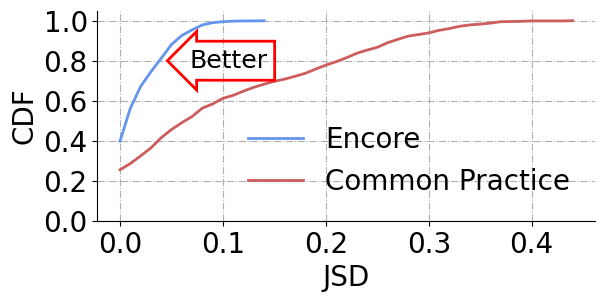

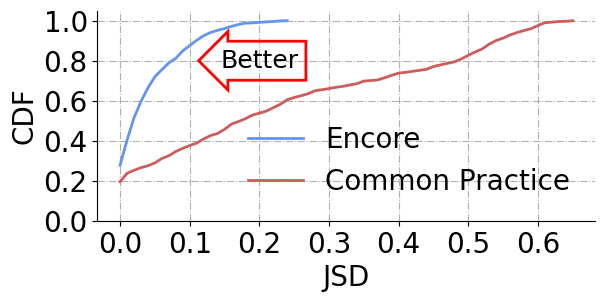

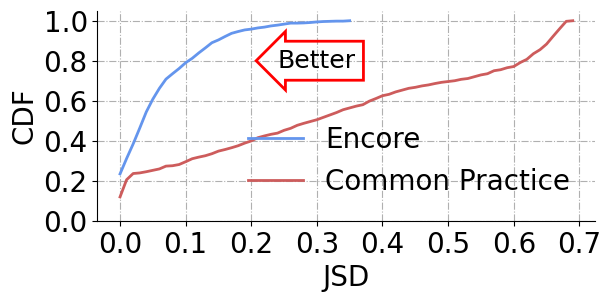

In [17]:
import matplotlib.pyplot as plt

for i in range(2, 5):
    plt.figure(figsize=(6, 3))
    plt.subplots_adjust(left=0.15, top=0.95, bottom=0.25, right=0.98)
    ax = plt.subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    values, bins = np.histogram(encore_jsds[i], bins=np.arange(0, np.max(encore_jsds[i]) + 0.01, 0.01))
    cdf = np.cumsum(values) / np.sum(values)
    plt.plot(bins[:-1], cdf, linewidth=2, color='CornFlowerBlue', label='Encore')
    values, bins = np.histogram(he_jsds[i], bins=np.arange(0, np.max(he_jsds[i]) + 0.01, 0.01))
    cdf = np.cumsum(values) / np.sum(values)
    plt.plot(bins[:-1], cdf, linewidth=2, color='IndianRed', label='Common Practice')
    plt.ylim(0, 1.05)
    plt.legend(fontsize=20, frameon=False)
    plt.ylabel('CDF', fontsize=20)
    plt.xlabel('JSD', fontsize=20)
    plt.grid(linestyle='-.')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    if i == 2:
        bbox_props = dict(boxstyle="larrow", fc="none", ec="red", lw=2)
        t = ax.text(0.105, 0.8, "Better", ha="center", va="center", rotation=0,
                    size=18,
                    bbox=bbox_props)
    elif i == 3:
        bbox_props = dict(boxstyle="larrow", fc="none", ec="red", lw=2)
        t = ax.text(0.2, 0.8, "Better", ha="center", va="center", rotation=0,
                    size=18,
                    bbox=bbox_props)
    else:
        bbox_props = dict(boxstyle="larrow", fc="none", ec="red", lw=2)
        t = ax.text(0.3, 0.8, "Better", ha="center", va="center", rotation=0,
                    size=18,
                    bbox=bbox_props)
    plt.savefig('figure/{i}-gram-jsd.png'.format(i=i), dpi=300)

In [41]:
for i in [50, 90, 95, 99]:
    print(i, np.percentile(rnn_jsds, i), np.percentile(he_jsds, i))

50 0.016796066997483282 0.07346432855368562
90 0.07909204873483928 0.2751986895385197
95 0.09532450370252392 0.31491465589104833
99 0.1320168295307611 0.3700949495105308


In [136]:
for i in [50, 90, 95, 99]:
    print(i, np.percentile(rnn_jsds, i), np.percentile(he_jsds, i))

50 0.012160265192768834 0.07145898533012404
90 0.047915725836543216 0.2727736298325866
95 0.053717750535610495 0.3153216864822403
99 0.06597230544940674 0.36794891171362076


In [10]:
# torch.save(gru, 'models/gru-0504.pth')
# torch.save(s2h, 'models/s2h-0504.pth')

In [11]:
class SizeDecoder(torch.nn.Module):
    def __init__(self, output_dim, hidden_dims, latent_dim):
        super(SizeDecoder, self).__init__()
        self.decoder = torch.nn.ModuleList()
        in_dim = latent_dim
        for h_dim in hidden_dims:
            self.decoder.append(
                nn.Sequential(
                    nn.Linear(in_dim, out_features=h_dim,),
                    nn.ReLU())
            )
            in_dim = h_dim
        self.output = nn.Linear(hidden_dims[-1], output_dim)
    
    def forward(self, x: Tensor) -> List[Tensor]:
        for module in self.decoder:
            x = module(x)
        result = self.output(x)
        result = F.softmax(result, dim=1)
        return result
    
decoder = torch.load('models/size-decoder-0425.pth')
gru = torch.load('models/gru-0504.pth')
s2h = torch.load('models/s2h-0504.pth')

In [50]:
from scipy.stats import entropy
from tqdm import tqdm
def JSD(p, q):
    p = list(p)
    q = list(q)
    pq_max_len = max(len(p), len(q))
    p += [0.0] * (pq_max_len - len(p))
    q += [0.0] * (pq_max_len - len(q))
    assert (len(p) == len(q))
    m = np.sum([p, q], axis=0) / 2
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

def sample_noisy_dataset(n, seed):
    torch.manual_seed(seed)
    dataset = []
    for i in tqdm(range(n)):
        latent_dim = 32
        z = torch.randn((1, latent_dim)).to(device)
        size = decoder(z)
        size = size.squeeze().detach().to('cpu').numpy()
        size[size < 1e-3] = 0
        size /= size.sum()

        dis = []
        for j in range(1000):
            loss = JSD(size, sizedata[j])
            dis.append(loss)

        pair = np.argmin(dis)
        ran_index = np.random.randint(len(seq_set[pair]))
        dataset.append([seq_set[pair][ran_index], size, target_set[pair][ran_index]])
        
    return dataset

In [71]:
a = []
for i in tqdm(range(1000)):
    torch.manual_seed(i)
    latent_dim = 32
    z = torch.randn((1, latent_dim)).to(device)
    size = decoder(z)
    size = size.squeeze().detach().to('cpu').numpy()
    size[size < 1e-3] = 0
    size /= size.sum()

    dis = []
    for j in range(1000):
        loss = JSD(size, sizedata[j])
        dis.append(loss)

    pair = np.argmin(dis)
    a.append(pair)

100%|██████████| 5000/5000 [05:13<00:00, 15.93it/s]


In [47]:
lr = 1e-3
# optimizer = torch.optim.Adam([{'params': s2h.parameters()}], lr=lr)
optimizer = torch.optim.Adam([{'params': gru.parameters()}, {'params': s2h.parameters()}], lr=lr)

s_time = time.time()
plot_every = 100
avg_loss = 0
for i in range(1000001):
    dataset = sample_dataset(i)
    ran_index = np.random.permutation(len(tune_dataset))[0:1000]
    # dataset.extend([tune_dataset[i] for i in ran_index])
    dataloader = DataLoader(dataset, batch_size=2000, shuffle=True)
    loss = train(dataloader, optimizer)
    avg_loss += loss
    if i and i % plot_every == 0:
        print(i, loss, avg_loss / plot_every, time.time() - s_time)
        if avg_loss / plot_every < 0.1:
            print(i, avg_loss / plot_every)
            break
        avg_loss = 0

100 0.37469881772994995 0.36950908958911893 11.19027829170227
200 0.36915746331214905 0.35975850641727447 21.188878059387207
300 0.35969191789627075 0.35673402369022367 32.09577918052673


KeyboardInterrupt: 

In [74]:
from tqdm import tqdm
a = set()
for i in tqdm(range(1000)):
    torch.manual_seed(i)
    latent_dim = 32
    z = torch.randn((1, latent_dim)).to(device)
    size = decoder(z)
    size = size.squeeze().detach().to('cpu').numpy()
    size[size < 1e-3] = 0
    size /= size.sum()

    dis = []
    for j in range(1000):
        loss = JSD(size, sizedata[j])
        dis.append(loss)
        # if loss < 0.02:
        #     a.add(j)

    pair = np.argmin(dis)
    a.add(pair)

100%|██████████| 1000/1000 [00:58<00:00, 17.09it/s]


In [73]:
jsds = np.zeros((1000, 1000))
for i in range(1000):
    for j in range(1000):
        jsds[i][j] = JSD(sizedata[i], sizedata[j])

In [75]:
np.sort(jsds[8])

array([0.        , 0.0712686 , 0.0989841 , 0.10461984, 0.10732551,
       0.11061315, 0.11413909, 0.11538036, 0.11660952, 0.11782312,
       0.12270552, 0.12357579, 0.12381709, 0.12831985, 0.12900488,
       0.13021052, 0.13290488, 0.13328528, 0.13464494, 0.13588953,
       0.13698097, 0.13924533, 0.14027519, 0.14082266, 0.14095486,
       0.14102039, 0.14222849, 0.14290341, 0.14387662, 0.14660579,
       0.14678407, 0.14694698, 0.14717077, 0.14719107, 0.14890525,
       0.14939437, 0.14958512, 0.15188435, 0.1524103 , 0.15251156,
       0.15369764, 0.1559504 , 0.15639397, 0.15688702, 0.15898742,
       0.15899087, 0.16149691, 0.16396171, 0.16474164, 0.16477304,
       0.1657369 , 0.16581361, 0.16621777, 0.16631866, 0.1666306 ,
       0.16702055, 0.16783559, 0.16789516, 0.16937711, 0.16999767,
       0.17006917, 0.17089419, 0.17237322, 0.17269899, 0.17295262,
       0.17311279, 0.1738042 , 0.17434601, 0.17441435, 0.17492409,
       0.17498089, 0.17590966, 0.17673751, 0.1767769 , 0.17685

In [65]:
(jsds < 0.01).sum(axis=1)

array([  2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   3,   1,   1,  95,   1,   1,   1,   1,   1,   2,   1,  96,
         1,   1,   1,   4,   1,   2,   1,   1,   1,   1,   2,   1,   3,
         1,   1,   1,   2,   3,   1,   1,   2,   4,   2,   1,   1,   1,
         2,   1,   2,   1,   1,   1,   1,   1,   1,   1,   4,   3,   1,
         3,   1,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   3,
         1,   1,   6,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   3,   1,   1,   1,   1,   1,   1,   6,
         2,   1,   1,   4,   1,   2,   1,   1,   1,   1,   1,   1,   4,
         1,   1,   1,   1,   1,   1,   1,  76,   2,   1,   1,  29,   1,
         1,   4,   5,   1,   1,   1,   1,   1,   2,   1,   1,   5,   7,
         4,   1,   2,   1,   5,   1,   4,   1,   1,   1,   1,  20,   7,
         5,   1,   1,   1,   1,   1,   1,   1,   5,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   4,   2,   1,   1,   1,   1,   